# Orders - Multivariate Regression of review_score

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# import orders dataset
from olistdash.order import Order

orders = Order().get_training_data(with_distance_seller_customer=True)

- Based on the correlation matrix below, we notice that `review_score` is mostly correlated with the two features `wait_time` and `delay_vs_expected`. However, these two features are also highly correlated with each other. 
- Using `statsmodels` to distinguish the effect of one feature, **holding the other one constant**.

<AxesSubplot:>

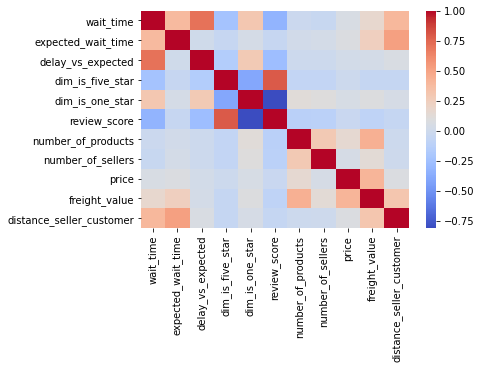

In [4]:
sns.heatmap(orders.corr(), cmap='coolwarm')

(0.0, 5.928612022448476)

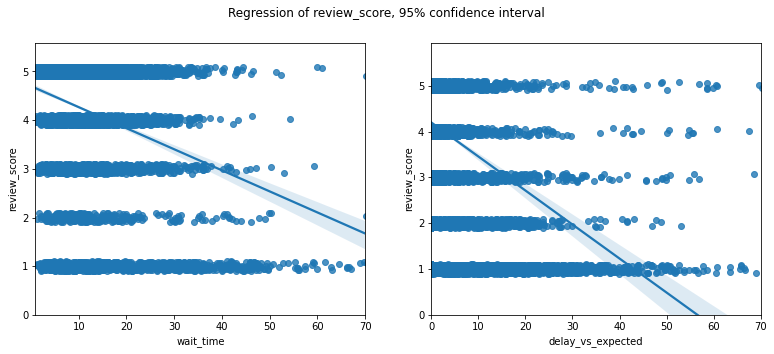

In [5]:
sample = orders.sample(10000, random_state=42)

plt.figure(figsize=(13, 5))

plt.suptitle('Regression of review_score, 95% confidence interval')

plt.subplot(1, 2, 1)
sns.regplot(x=sample.wait_time, y=sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
sns.regplot(x=orders.delay_vs_expected,
            y=orders.review_score,
            y_jitter=.1,
            ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

## 1 - Univariate regression

Using [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) with `statsmodels.formula.api` to quickly make
 - `model1`: an ols regression of `review_score` over `wait_time`
 - `model2`: an ols regression of `review_score` over `delay_vs_expected`

Printing the `summary` table and interpret the results for each:
- Regression performance metric R-squared, individual regression coefficients, t-values, p-values, and 95% confidence intervals

`*(OLS Regression) Ordinary least squares regression`

In [8]:
import statsmodels.formula.api as smf

In [10]:
# Model 1
model1 = smf.ols('review_score ~ wait_time', data=orders).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.221e+04
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:29:02   Log-Likelihood:            -1.5630e+05
No. Observations:               96525   AIC:                         3.126e+05
Df Residuals:                   96523   BIC:                         3.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7138      0.006    725.216      0.0

In [11]:
# Model 2
model2 = smf.ols('review_score ~ delay_vs_expected', data=orders).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7710.
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:29:15   Log-Likelihood:            -1.5834e+05
No. Observations:               96525   AIC:                         3.167e+05
Df Residuals:                   96523   BIC:                         3.167e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1994      0.00

## 2 - Multivariate regression

What is the impact on `review_score` of adding one day of `delay_vs_expected` to the order, **holding `wait_time` constant**? Which of the two features is the most explicative for the low `review_score`?

Running an OLS model `model3` where both `wait_time` and `delay_vs_expected` are the features (independent variables), and `review_score` is the target (dependent variable).

In [12]:
# Model 3
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected',
                 data=orders).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     6254.
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:32:56   Log-Likelihood:            -1.5616e+05
No. Observations:               96525   AIC:                         3.123e+05
Df Residuals:                   96522   BIC:                         3.124e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6442      0.00

----
The multivariate regression allows us to isolate the impact of one feature, while controlling the effect of other features. These new coefficients are called **partial correlation** coefficients.


- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0191 [0.017 - 0.21] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0388 points 

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`. This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors.

---
R-squared is quite low: no more than 12% of the variations of review_score is explained by the combined variations of `wait_time` and `delay_vs_expected`. Trying to add more features to the regression to improve explainability.

- Creating a new OLS `model4` with more features from `orders` dataset.

In [13]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

In [16]:
# standardizing features
orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)

orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431707,15.544063,-0.162787,delivered,0,0,4,-0.264004,-0.112813,-0.511860,-0.651997,-0.979467
1,53cdb2fc8bc7dce0b6741e2150273451,0.128587,19.137766,-0.162787,delivered,0,0,4,-0.264004,-0.112813,-0.087278,-0.000604,0.428808
2,47770eb9100c2d0c44946d9cf07ec65d,-0.331330,26.639711,-0.162787,delivered,1,0,5,-0.264004,-0.112813,0.109912,-0.164844,-0.146045
3,949d5b44dbf5de918fe9c16f97b45f8a,0.068497,26.188819,-0.162787,delivered,1,0,5,-0.264004,-0.112813,-0.440019,0.205392,2.052600
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.014771,12.112049,-0.162787,delivered,1,0,5,-0.264004,-0.112813,-0.560153,-0.651997,-0.959121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96528,9c5dedf39a927c1b2549525ed64a053c,-0.454616,18.587442,-0.162787,delivered,1,0,5,-0.264004,-0.112813,-0.310793,-0.449712,-0.893083
96529,63943bddc261676b46f01ca7ac2f7bd8,1.010273,23.459051,-0.162787,delivered,0,0,4,-0.264004,-0.112813,0.181705,-0.124016,-0.213301
96530,83c1379a015df1e13d02aae0204711ab,1.289682,30.384225,-0.162787,delivered,1,0,5,-0.264004,-0.112813,0.330507,1.960071,0.616570
96531,11c177c8e97725db2631073c19f07b62,0.474942,37.105243,-0.162787,delivered,0,0,2,1.586072,-0.112813,1.067531,2.709822,-0.387946


In [17]:
# Creating and training MODEL4
formula = "review_score ~ " + ' + '.join(features)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers + price + freight_value + distance_seller_customer'

In [18]:
model4 = smf.ols(formula=formula, data=orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2348.
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:39:09   Log-Likelihood:            -1.5446e+05
No. Observations:               96525   AIC:                         3.089e+05
Df Residuals:                   96517   BIC:                         3.090e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

---
Bar chart to visualize more important features.
- How has the overall regression performance changed?
- Is this regression statistically significant?

In [20]:
model4.params

Intercept                   4.142005
wait_time                  -0.450029
delay_vs_expected          -0.044982
number_of_products         -0.132475
number_of_sellers          -0.131830
price                      -0.004405
freight_value               0.004872
distance_seller_customer    0.098776
dtype: float64

<AxesSubplot:>

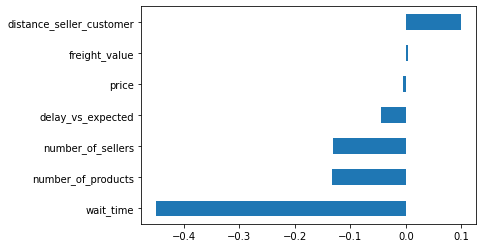

In [19]:
model4.params[1:].sort_values().plot(kind='barh')

- `wait_time` is the biggest explanatory variable
- The more `products` and `sellers` there are for a single order, the lower the `review_score`. 
- Distance also plays a role.a
    
- Overall, this multivariate regression remains statistically significant, because its F-statistics are much greater than 1 (at least one feature has a very low p-value)

- R-squared hasn't increased by much. Most of the explanability of review_score lies outside of the orders dataset.

Low R-squared is common when the number of observations (n) is much higher than the number of features (p). Relevant insights can still be derived from such regressions, provided they are statistically significant.

## 3 - Checking model performance

Regression performance should not be measured only by it's R-squared.
It is always important to visualize the distribution of the predictions, and especially the residuals.

- Computing the residuals.
Their mean is equal to 0 (always the case in linear regression)
- Computing the associated RMSE.
- Ploting the `residuals` in a histogram.

In [21]:
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score

In [22]:
RMSE = (residuals.map(lambda x: x**2).sum() / len(residuals))**0.5
RMSE

1.1986853369569426

Text(0.5, 1.0, 'residuals density plot')

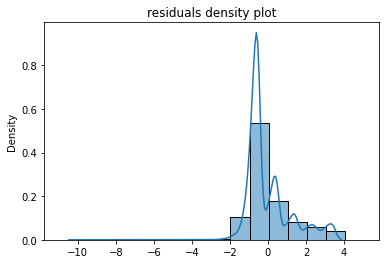

In [23]:
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

Plotting on the same axis the histogram of `review_score` as well as that of the `predicted_review_score` for each row of the dataset to understand the strange shape of the residual distplot.

Text(0.5, 1.0, 'distribution of predicted and actual values')

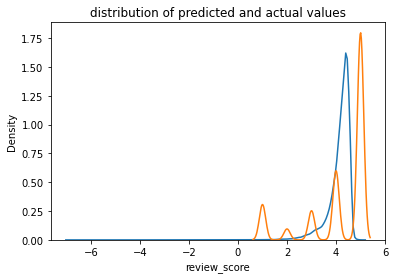

In [24]:
sns.kdeplot(predicted_review_score, label='predicted review score')
sns.kdeplot(orders.review_score, label='actual review score')
plt.title('distribution of predicted and actual values')

☝️ This model is not so great, for two reasons
- First, because it doesn't have enough features to explain a significant proportion of the review_scores (low R-squared)
- Secondly, because it is done by trying to fit a "linear regression" function to a discreet classification problem